In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt,style
style.use('ggplot')
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_test=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#checking the shape of data frame
print(df_train.shape)
print(df_test.shape)

(1460, 81)
(1459, 80)


In [4]:
#checking the traget/otput columns
import numpy as np
np.setdiff1d(df_train.columns,df_test.columns)

array(['SalePrice'], dtype=object)

## Understanding the DataType:

In [5]:
df=pd.concat([df_train,df_test],keys=['x','y'])

In [6]:
# checking the datatypes of all the  features in the dataset
print('object_datatype:'+ str(df.select_dtypes('object').shape))
print('********')
print('int64_datatype:'+ str(df.select_dtypes('int64').shape))
print('********')
print('float_datatype:'+ str(df.select_dtypes('float').shape))
print('********')
print('bool_datatype:'+ str(df.select_dtypes('bool').shape))

object_datatype:(2919, 43)
********
int64_datatype:(2919, 26)
********
float_datatype:(2919, 12)
********
bool_datatype:(2919, 0)


In [7]:
#dividing the dataset into cateogrical ,year and numerical

Cate,Nume,year=[],[],[]
import re
for i in df.columns:
    if df[i].dtypes=='object':
        Cate.append(i)
    elif re.search(r'Yr|YR|YEAR|Year|year|yr',i):
        year.append(i)
    else:      
        Nume.append(i)
print(len(Cate))
print(len(Nume))
print(year)

43
34
['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']


## Explore data (gain insights)*

[Text(0.5, 1.0, 'YrSold - GarageYrBlt')]

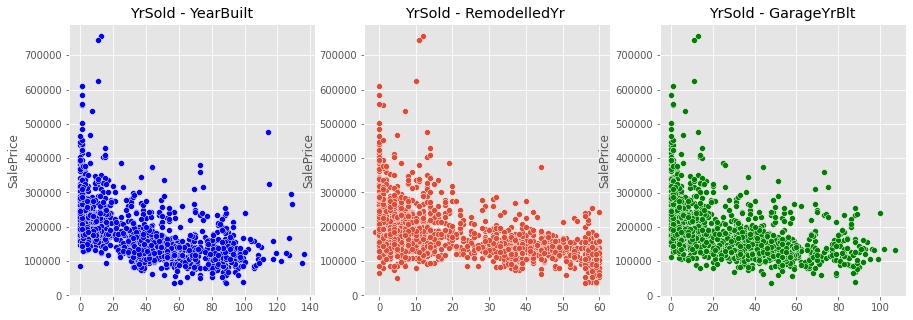

In [8]:
#checking how year features  are  impacting  the SalePrice
#normally the assumtion is recently constructed/remodelled house will have higher price
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(np.subtract(df.YrSold,df.YearBuilt),df.SalePrice,color='blue').set(title='YrSold - YearBuilt')
plt.subplot(1,3,2)
sns.scatterplot(np.subtract(df.YrSold,df.YearRemodAdd),df.SalePrice).set(title='YrSold - RemodelledYr ')
plt.subplot(1,3,3)
sns.scatterplot(np.subtract(df.YrSold,df.GarageYrBlt),df.SalePrice,color='green').set(title='YrSold - GarageYrBlt')

We can see there are quite a few outliers ,where the houses are 100+ year old and prices are more than 250K.We will do little more analysis before removing the outliers ,such as how mig is the house,how many rooms are thgere.etc

<AxesSubplot:>

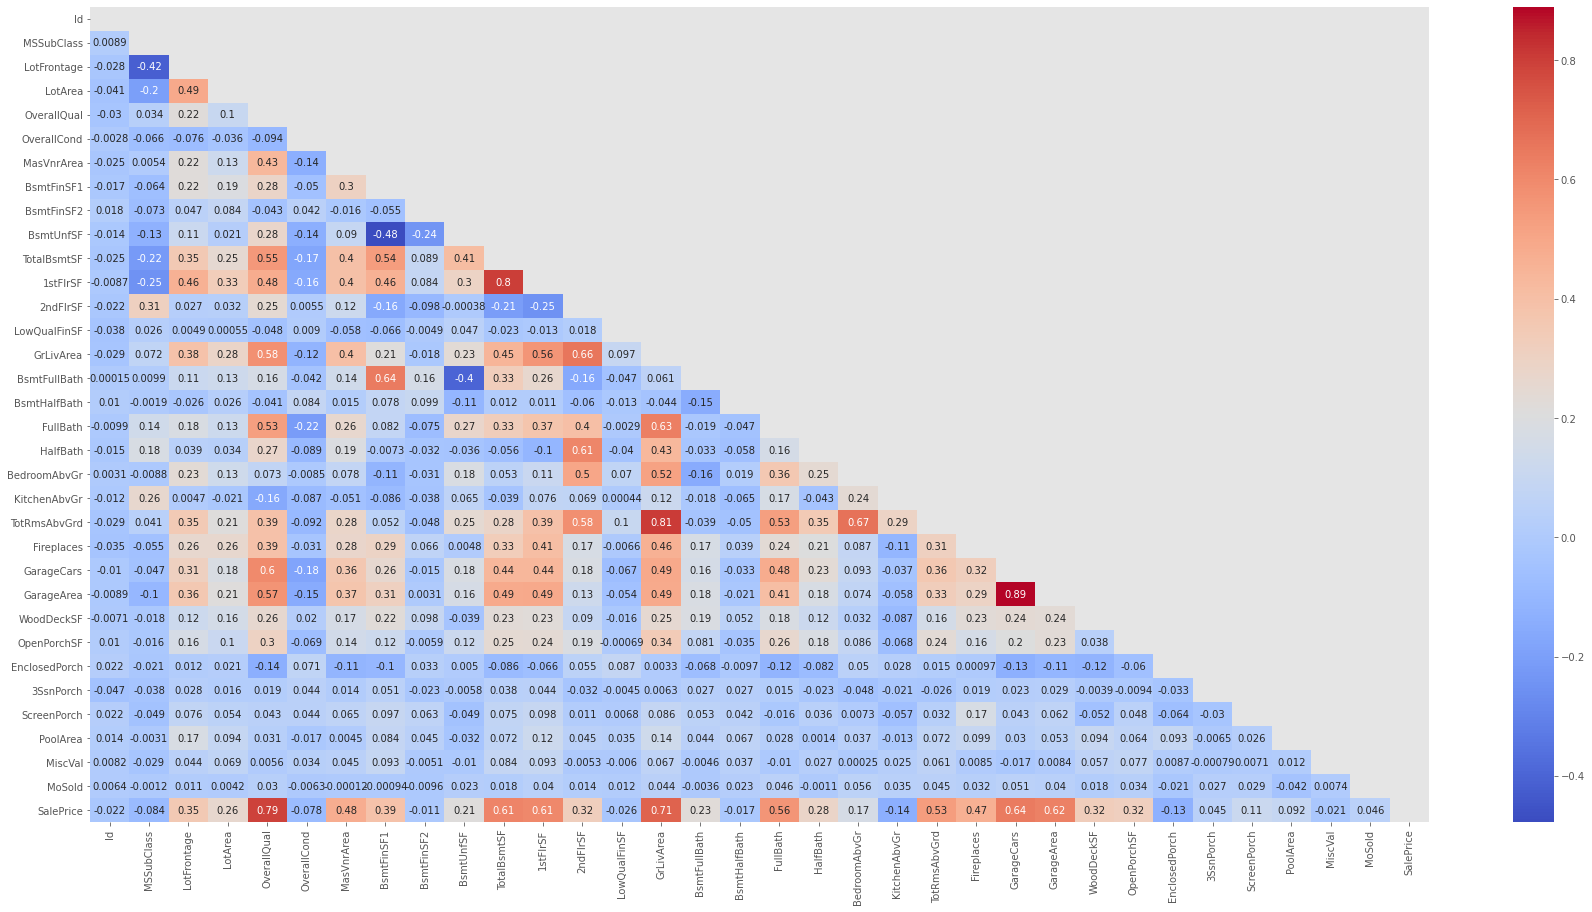

In [9]:
#checking how Cateogrical features  are  impacting  the SalePrice
plt.figure(figsize=(30,15))
matrix = np.triu(df[Nume].corr())#or tril
sns.heatmap(df[Nume].corr(),annot=True, mask=matrix,cmap= 'coolwarm')

Analysis:
1> Features that has high impcat on SalePrice='OverallQual','TotalBsmtSF',1stFlrSf,GrLivArea,FullBath,GarageCars,GarageArea,

2> lease significant features for SalePrice=Id,MSSubclass,BsmtFinSF2,overAllCond,LowQuaFinSF,EnclosedPorch,KitchenAbvGr,BsmtHalfBath

3> Few features are highly correlated=TotRmsAbvGrd and GrLivArea,fullBath and GrLivArea,GarageCars and GarageArea,TotalBsmtSf and 1stFlrSF

<AxesSubplot:>

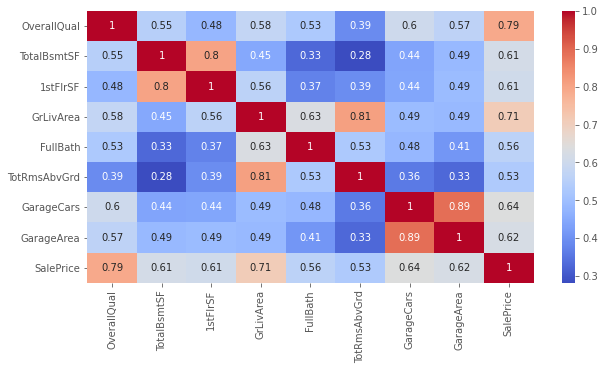

In [10]:
#getting the highly  correlated numerical features:
plt.figure(figsize=(10,5))
filte_corr=df[Nume].corr().index[abs(df[Nume].corr()['SalePrice'])>0.5]
Matrix = np.tril((df[Nume].corr()))
sns.heatmap(df[Nume][filte_corr].corr(),annot=True, cmap= 'coolwarm')


we can drop the features which are highly correlated.Normally the threshold is the features which are correlated by more than .7 ,just keep one of them.
Later we will drop these features:TotalBsmtSf,TotRmsAbvGrd,GarageCars.

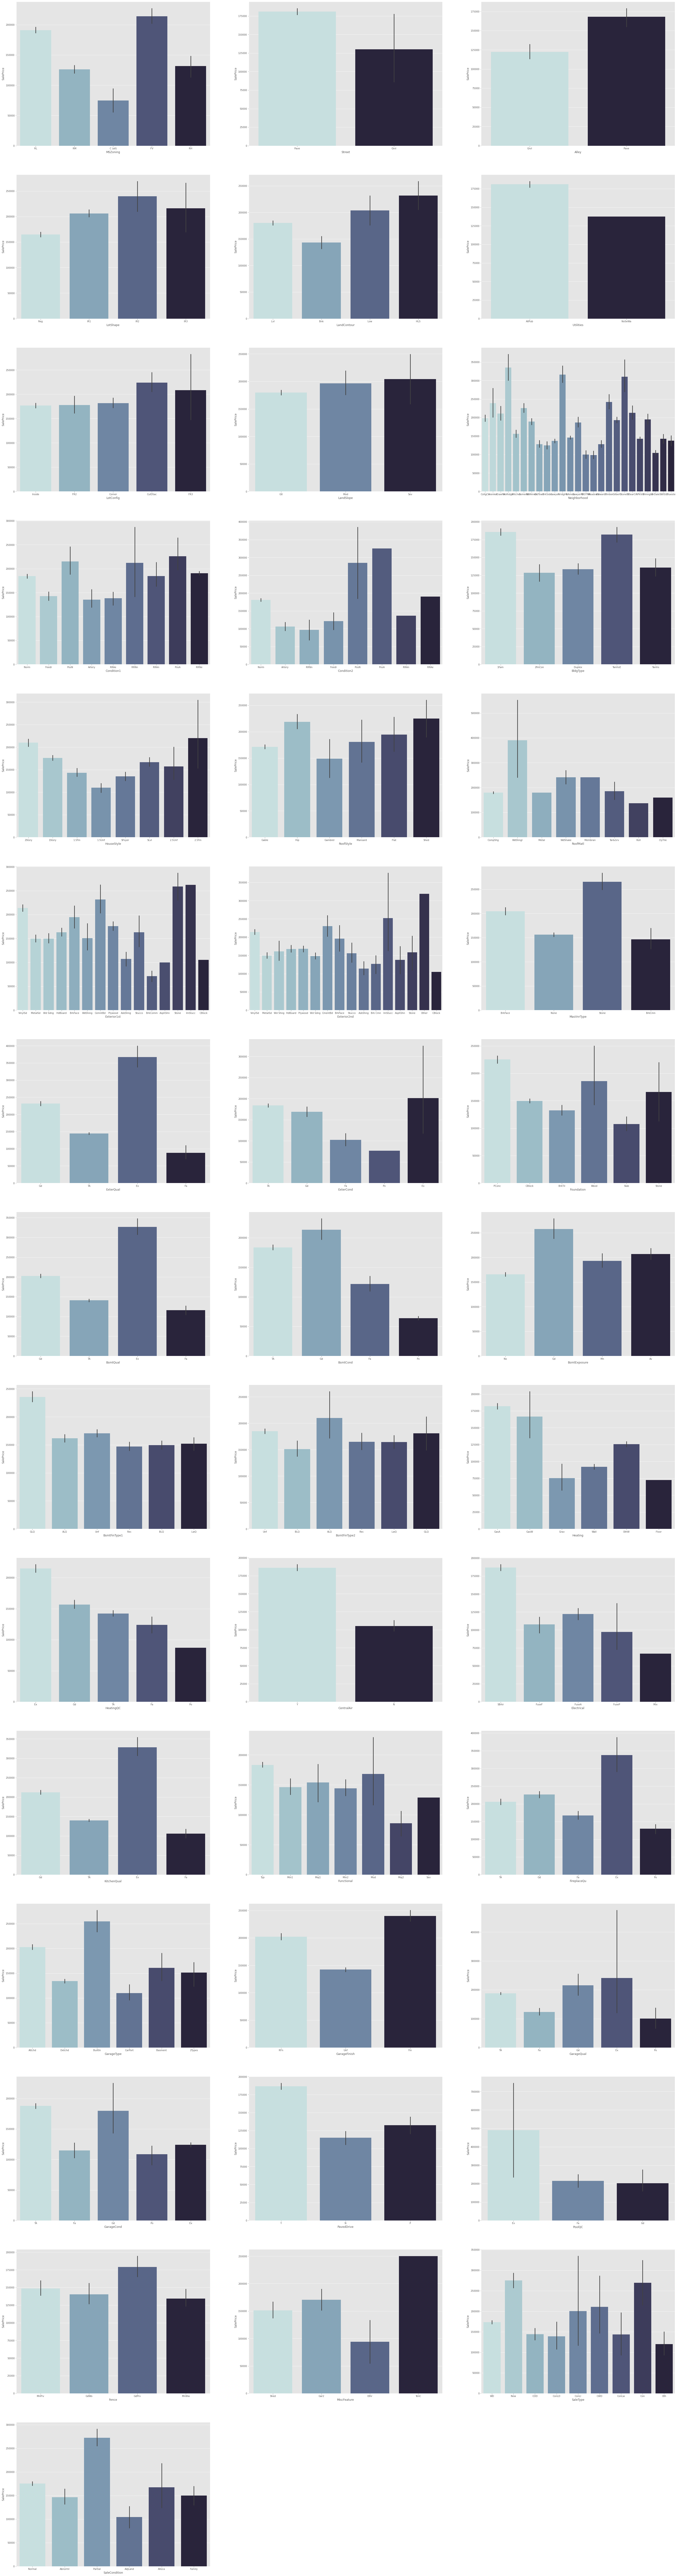

In [11]:
#getting the numbers and counts in each cateogrical variable
plt.figure(figsize=(50,200))
for i,feat in enumerate(Cate) :
    #print('no of unique value in  {} is : \n{}'.format(i,df[i].value_counts()))
    plt.subplot(15,3,i+1)
    sns.barplot(data=df,x=feat,y=df.SalePrice,palette="ch:start=.2,rot=-.3")
    #sns.color_palette("crest", as_cmap=True)

After analysing we can say that following features are not have mucg of a diffrence on SalePrice:
LandConfig,LandSlope,Roofstyle,Bldgtyp2,Fence,Functional

#'YrSold','LowQualFinSF','BsmtHalfBath','MSSubClass','OverallCond','BsmtFinSF2'

### Handling Outliers

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

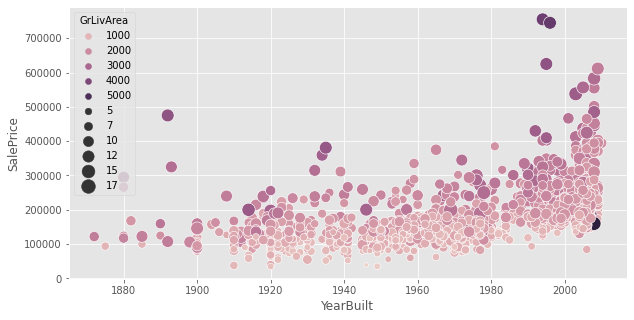

In [12]:
#checking the outliers- 1:
plt.figure(figsize=(10,5))
A=sum([df_train['BsmtFullBath'],df_train['BsmtHalfBath'],df_train['FullBath'],df_train['HalfBath'],df_train['TotRmsAbvGrd']])
area=sum([df_train['GrLivArea']])
sns.scatterplot(data=df_train,x='YearBuilt',y='SalePrice',hue=area,sizes=(20, 200), size=A)

1. Analysis
- Majority of the data population is looking for the houses built after 1940.
- There is surge in sale price after 1980
- More the number of room and more the living area greater in the saleprice
- There are some houses which has more than 16 rooms+bathrooms but still the price is really low, even if they are built after 2000.Those kind of records are ourliers and we need to remove those records.
- There are 2 records with saleprice more than 700K,it looks like outliers but they have 16 rooms+bathrooms and they are in a neighborhood where average saleprice 350K.hence we will keep these records.

In [13]:
df_train['Total_rooms+bath']=sum([df_train['BsmtFullBath'],df_train['BsmtHalfBath'],df_train['FullBath'],df_train['HalfBath'],df_train['TotRmsAbvGrd']])
df_train=df_train[~((df_train['Total_rooms+bath']>16) & (df_train.SalePrice<300000))]
#df_train=df_train[~(df_train.SalePrice>700000)]

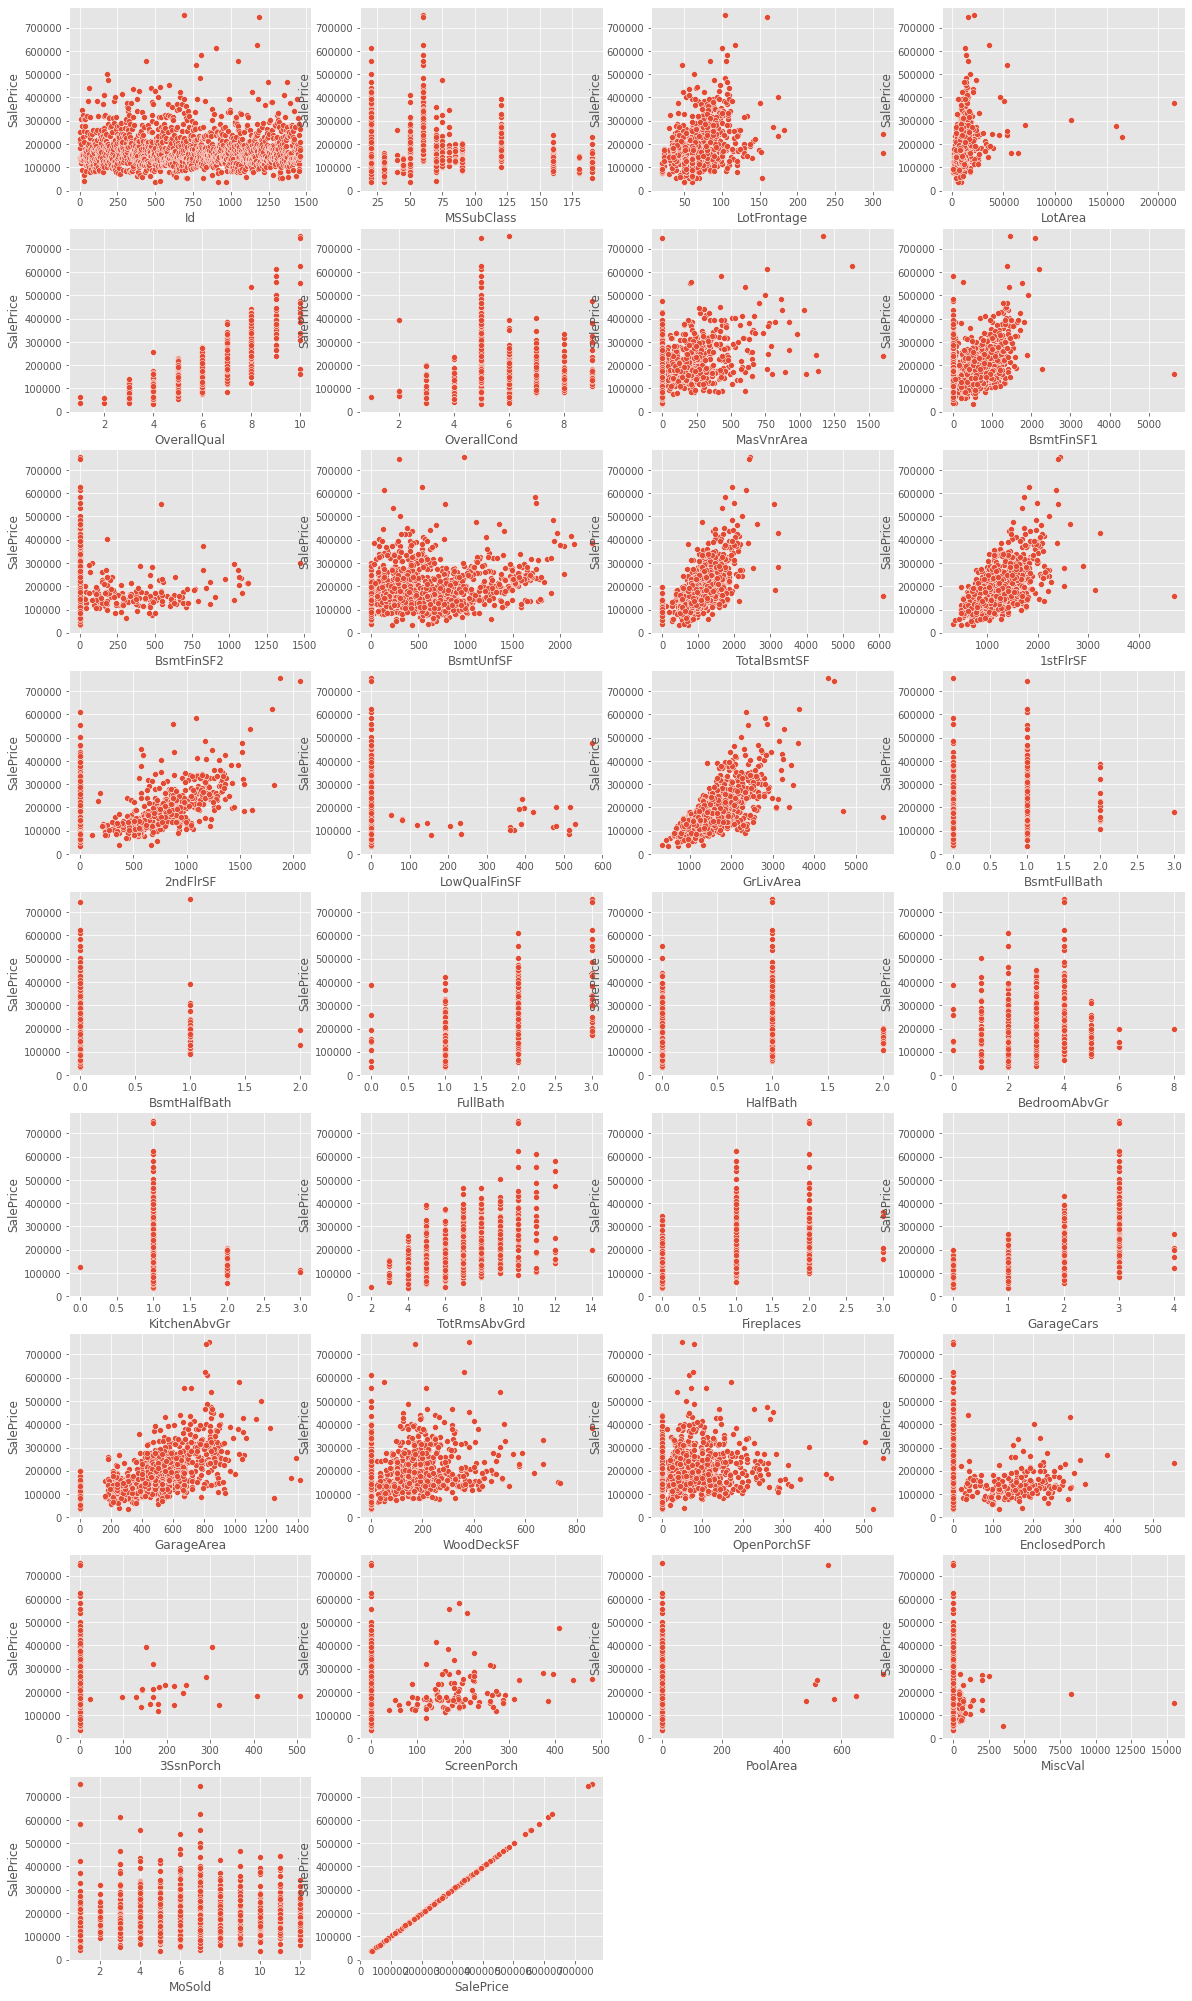

In [14]:
#Outliers2:
plt.figure(figsize=(20,40))
for i,feat in enumerate(Nume) :
    #print('no of unique value in  {} is : \n{}'.format(i,df[i].value_counts()))
    plt.subplot(10,4,i+1)
    sns.scatterplot(data=df,x=feat,y=df.SalePrice,palette="ch:start=.2,rot=-.3")

We can see there are quite a few outliers in the numerical data type.
'LotFrontage','LotArea',MasVnrArea',TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,'OpenPorchSF','EnclosedPorch','ScreenPorch'


In [15]:

df.LotFrontage[(df.LotFrontage >= 200)] = 200
df.LotArea[(df.LotArea >= 75000)] = 75000
df.MasVnrArea[(df.MasVnrArea >= 1000)] = 1000
df.BsmtFinSF1[(df.BsmtFinSF1 >= 2500)] = 2500
df.TotalBsmtSF[(df.TotalBsmtSF >= 3000)] = 3000
df['1stFlrSF'][(df['1stFlrSF'] >= 3000)] = 3000
df.GrLivArea[(df.GrLivArea >= 3500)] = 3500
df.GarageArea[(df.GarageArea >= 1500)] = 1500
df.OpenPorchSF[(df.OpenPorchSF>=400) & (df.SalePrice<100000)]=400
df.SalePrice[(df.OpenPorchSF>=400) & (df.SalePrice<100000)]=250000
#df.EnclosedPorch[(df.EnclosedPorch>=450)]=450
#.ScreenPorch[(df.ScreenPorch>=350)]=350
#df['3SsnPorch'][(df['3SsnPorch']>=350)]=350

### Handling Missing Values

In [16]:
#checking the missing value and the percentage
def miss_val(df):
   miss_col=df[[col for col in df.columns if df[col].isnull().any() == True]].isna().sum()
   con=miss_col/df[[col for col in df.columns if df[col].isnull().any() == True]].isna().count()
   return pd.concat([miss_col,con],keys=['missing_count','percentage'],axis=1).sort_values('percentage',ascending=False)
miss_val(df)

,missing_count,percentage
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


We have a lot of missing data in our dataset .Now we have to decide based on our domain knowledge ,we will decide how to fill/drop thos Nas value.

1. We will follow the below mentioned steps to handle  missing values : 
   - we will ignore all those records where percentage is less than .02.we will either drop or fill 0 for those records.
   - Some of these missing counts can be grouped together and then similar values can be filled in.Ex Basment and Garage related columns with        missing value.the missing value numbers are kind ofWe can check if the missing value is in the same row,if yes we can handle it accordingly.
   - Feathures like POOLQC,FireplaceQu  are based on  other features like PoolArea and Fireplaces.We will check those feature and if there is       no fireplace or pool we will fill the value as 0 .
   - MiscFeature .Alley is not much of use here  ,it does not impact buyers decision of buing a house ,it is just extra feature.
   - Fence : if a house has a pool ,we know it has to have a fence,so we will check the pool feature to fill for this one.
   - GarageYrBlt -we can check YearRemodAdd' to fill in the NA values in this one.

In [17]:
def df_miss(df):
    df[['GarageFinish','GarageQual','GarageCond','GarageType']]= df[['GarageFinish','GarageQual','GarageCond','GarageType']].fillna("None")
    df['GarageYrBlt']=df['GarageYrBlt'].fillna(0)
    df[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']]=df[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']].fillna("None")
    df.LotFrontage=df.LotFrontage.fillna(df.LotFrontage.median())
    df.MasVnrArea=df.MasVnrArea.fillna(0.0)
    df.MasVnrType=df.MasVnrType.fillna(df.MasVnrType.mode()[0])
    df.MSZoning=df.MSZoning.fillna(df.MSZoning.mode()[0])
    df['FireplaceQu']=np.where(df['Fireplaces']==0,"NA", df['FireplaceQu'].fillna("NA"))
    df['PoolQC']=np.where(df['PoolArea']==0, "NA", df['PoolQC'].fillna("NA"))
    df[['Utilities','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2','GarageArea','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]=df[['Utilities','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1','GarageArea','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(0)
    df[['SaleType','Exterior1st','Exterior2nd','Electrical','KitchenQual']]=df[['SaleType','Exterior1st','Exterior2nd','Electrical','KitchenQual']].fillna("NA")
    df.Functional =df.Functional .fillna("NA")
    df.GarageCars=df['GarageArea']==0
    df=df.drop(columns=['Alley','Fence','MiscFeature','TotalBsmtSF','TotRmsAbvGrd','GarageCars'])
    #df[['Alley','Fence','MiscFeature']]=df[['Alley','Fence','MiscFeature']].fillna("NAD")
    return df[[col for col in df.columns if df[col].isnull().any() == True]].isna().sum()
print(df_miss(df))

SalePrice    1459
dtype: int64


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

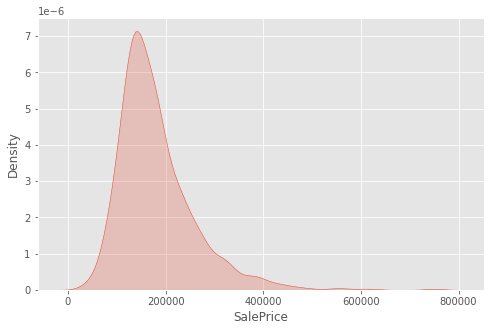

In [18]:
plt.figure(figsize=(8,5))
sns.kdeplot(df_train.SalePrice,common_norm=False,palette="husl",fill=True)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

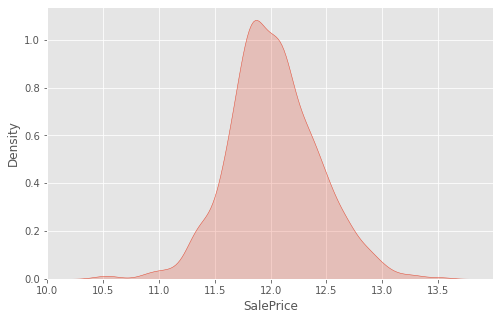

In [19]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(df_train.SalePrice),common_norm=False,palette="husl",fill=True)

SalePrice of any house depends on various factors:
1. Sqft area
2. Amenities 
3. year of build
4. Type of house
5. No of rooms/bathroom
6. Neibhorhood

We will try to focus on these feature and will gain insight about our data.

## Label Encoding

We will do both Hot encoding and Label incoding here.We should not go for one hot encoding where the cardinality is more means if we hav emutiple value_counts for a feature,it will lead to curse of dimensionality

In [20]:
#encoding the cateogrical variables
#from sklearn import preprocessing
#en_label = preprocessing.LabelEncoder()

#for i in df.select_dtypes('object'):
   #df[i]= en_label.fit_transform(df[i])

In [21]:
df_dummy=pd.get_dummies(data=df,drop_first=True)
df=df_dummy

In [22]:
from sklearn.feature_selection import VarianceThreshold
#threshold_n=0.05
sel = VarianceThreshold(threshold=.05)
sel_var=sel.fit_transform(df)
df=df[df.columns[sel.get_support(indices=True)]] 

In [23]:
#getting the train and test data back again
train_new=df.loc["x"]
test_new=df.loc["y"].drop(columns=['SalePrice','Id'])
train_new.shape

(1460, 114)

In [24]:
#Getting x and y

x=train_new.drop(columns=['SalePrice','Id'])
y=np.log(train_new.SalePrice)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=10)

In [26]:
#Splitting  the data into train and test

from sklearn.preprocessing import StandardScaler
stdSC=StandardScaler()
x_train_std=stdSC.fit_transform(x_train)
x_test_std=stdSC.fit_transform(x_test)
x_final_std=stdSC.fit_transform(test_new)

In [27]:
#Feature engineering
from sklearn.decomposition import PCA
PCAModel=PCA(108)
x_train_com=PCAModel.fit_transform(x_train_std)
x_test_com=PCAModel.transform(x_test_std)
test_new_com=PCAModel.transform(x_final_std)
PCAModel.explained_variance_
PCAModel.explained_variance_ratio_*100
import numpy as np
np.cumsum(PCAModel.explained_variance_ratio_*100)

array([ 13.55117176,  20.2238466 ,  25.38927339,  30.10506001,
        33.86078935,  36.74617579,  39.49041341,  41.70692555,
        43.83710393,  45.88218655,  47.75510479,  49.55307092,
        51.27220341,  52.94776978,  54.52328714,  55.99381971,
        57.39703285,  58.75896382,  60.10107701,  61.4104643 ,
        62.62955739,  63.79619966,  64.9338229 ,  66.04149995,
        67.14560052,  68.21302406,  69.2404294 ,  70.26040235,
        71.24534143,  72.21034989,  73.15892212,  74.08047611,
        74.97727626,  75.83708893,  76.68069315,  77.50809408,
        78.31260585,  79.09855508,  79.86490953,  80.62430499,
        81.36288406,  82.08143897,  82.78692701,  83.4705141 ,
        84.14535095,  84.78741958,  85.42361798,  86.02574046,
        86.62290922,  87.20654939,  87.775479  ,  88.31270731,
        88.84515821,  89.35403887,  89.86100169,  90.34899639,
        90.81442813,  91.26836447,  91.7123898 ,  92.12629408,
        92.53679072,  92.93451005,  93.30304277,  93.65

### Building Different models

In [28]:
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(max_depth=8)
rfr.fit(x_train,y_train)
y_predictrfr = rfr.predict(x_train)

#here we can check our model score
print(rfr.score(x_train,y_train))
print(rfr.score(x_test,y_test))



0.9641391477423543
0.854482161612621


In [29]:
from sklearn.linear_model import LinearRegression
model=LinearRegression(n_jobs=1000)
model.fit(x_train_com,y_train)
print('LR train model:' + str( model.score(x_train_com,y_train)))
print('LR test model:' + str(model.score(x_test_com,y_test)))


LR train model:0.9033054993117065
LR test model:0.8465308761373098


In [30]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
XGB=XGBRegressor(learning_rate=.1,max_depth=9,gamma=.001,reg_alpha=.001)
XGB.fit(x_train_std,y_train)
import numpy as np

print('XGB train model:' + str( XGB.score(x_train_std,y_train)))
print('XGB test  model:' + str(XGB.score(x_test_std,y_test)))
XGB.predict(x_test_std)
print('RMSE:' + str(np.sqrt(mean_squared_error(y_test,XGB.predict(x_test_std)))))
print(r2_score(y_test,XGB.predict(x_test_std)))

XGB train model:0.997505923932768
XGB test  model:0.877537064508322
RMSE:0.14641371380747503
0.877537064508322


In [31]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV,RidgeCV,ElasticNetCV
lassoModel=LassoCV(alphas=[1,0.1,0.001,.01,.00001])
lassoModel.fit(x_train_com,y_train)
print("Train Score (Linear):",lassoModel.score(x_train_com,y_train))
print("Test Score (Linear):",lassoModel.score(x_test_com,y_test))

Train Score (Linear): 0.8984962052965776
Test Score (Linear): 0.9026846942801463


In [32]:
from sklearn.linear_model import Ridge
RModel=RidgeCV(alphas=[1,0.1,0.001,.01,.0001])

RModel.fit(x_train_com,y_train)
print("Train Score (Linear):",RModel.score(x_train_com,y_train))
print("Test Score (Linear):",RModel.score(x_test_com,y_test))
print('RMSE:' + str(np.sqrt(mean_squared_error(y_test,RModel.predict(x_test_com)))))

Train Score (Linear): 0.9022576461094205
Test Score (Linear): 0.8972925030937099
RMSE:0.13408509269017635


In [33]:
#ElasticNet
from sklearn.linear_model import ElasticNet

EModel=ElasticNetCV(alphas=[1,0.1,0.003,.03,.00001])
EModel.fit(x_train_com,y_train)
print("Train Score (Linear):",EModel.score(x_train_com,y_train))
print("Test Score (Linear):",EModel.score(x_test_com,y_test))
print('RMSE:' + str(np.sqrt(mean_squared_error(y_test,EModel.predict(x_test_com)))))

Train Score (Linear): 0.8937008498897028
Test Score (Linear): 0.9024294197802727
RMSE:0.13068894972554645


#we can see the best model is ElasticNet model with R2 of 90.21 .We will use this model to predict our test data.

In [34]:

A=pd.DataFrame({'ID':df_test.Id,'SalePrice_log':EModel.predict(test_new_com)})
A['SalePrice'] = np.exp(A['SalePrice_log'])
A=A[['ID','SalePrice']]
A.to_csv("submission.csv",index=False)

#### 